In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
import json

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, accuracy_score, roc_auc_score, roc_curve
#from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

warnings.simplefilter("ignore", UserWarning)


PATH = '***'

# Load data #1

## Train

In [2]:
n_neigbours = 30

In [3]:
features_train = pd.read_csv(PATH + 'all_features_train.csv', index_col=0)
target_train = pd.read_csv(PATH + 'target_train.csv', index_col=0)
idx_d_train = pd.read_csv(PATH + 'faiss_idx_and_distances_train.csv', index_col=0)

In [4]:
features_train['distance'] = idx_d_train['1']
features_train['index'] = idx_d_train['0']
features_train['target'] = target_train

# CatBoost ranking

In [5]:
def metrics(y_true, y_pred, features):
    cm = (confusion_matrix(y_true, y_pred))
    print('Accuracy: ', round(accuracy_score(y_true, y_pred), 3))
    print('Precision: ', round(precision_score(y_true, y_pred), 3))
    print('Recall: ', round(recall_score(y_true, y_pred), 3))
    print('F1-score: ', round(f1_score(y_true, y_pred), 3))
    print('ROC-AUC: ', round(roc_auc_score(y_true, model.predict_proba(features)[:, 1]), 3))

    fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(features)[:, 1])
    plt.figure(figsize=(3, 3))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(cm, cmap=plt.cm.gnuplot, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=10)

## GridSearch

Searching for best params on stratified sample (20% of train data):

In [6]:
N = len(features_train)*0.2
sample = features_train.groupby('target', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(features_train))))).sample(frac=1).reset_index(drop=True)

In [7]:
y_sample = np.array(sample['target'])
X_sample = np.array(sample.drop(['target'], axis = 1))


In [8]:
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, 
                                                    test_size=0.2,                         
                                                    random_state=42,
                                                   stratify=y_sample)
print(X_sample_train.shape)
print(X_sample_test.shape)

(480000, 146)
(120000, 146)


In [9]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=42, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_sample_train, y_sample_train)

Learning rate set to 0.099163
0:	learn: 0.5253312	total: 452ms	remaining: 11m 17s
500:	learn: 0.0346990	total: 3m 10s	remaining: 6m 19s
1000:	learn: 0.0313512	total: 6m 4s	remaining: 3m 1s
1499:	learn: 0.0308764	total: 8m 33s	remaining: 0us


Accuracy:  0.988
Precision:  0.878
Recall:  0.582
F1-score:  0.7
ROC-AUC:  0.98


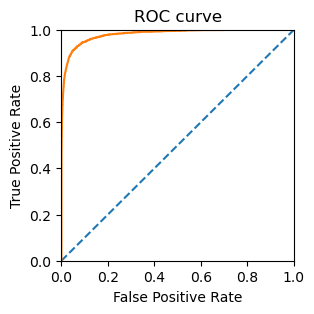

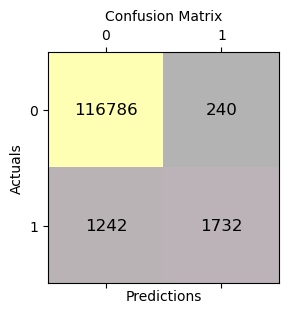

In [10]:
pred = model.predict(X_sample_test)
metrics(y_sample_test, pred, X_sample_test)

In [11]:
#model = CatBoostClassifier(verbose=False, iterations=1000, 
#                           random_seed=42, 
#                           loss_function='Logloss',
#                           boosting_type='Ordered')
#
#params = {'depth': range (3, 10)}

In [12]:
#grid = GridSearchCV(model, params, scoring='f1') 
#grid.fit(train_sample.drop(['target'], axis = 1), train_sample['target'])
#f1 = grid.best_score_
#print('F1 on stratified sample:', round(f1, 3))
#print(grid.best_params_)

## Train model

defining `metrics` function:

## Searching for best candidates

defining `best_candidates_search` function:

In [13]:
def best_candidates_search(df, n, cand_num, type):
    best_candidates_list = []
    for i in tqdm(range((len(df)// n))):
        best_c = df[n*i:n*(i+1)].sort_values(by='prob', ascending=False)[:cand_num]
        best_candidates_list.append(best_c)
        del best_c
    print('lists created...')    
    del df
    gc.collect()
    print('origin DF deleted...')    
    new_df = pd.DataFrame(np.concatenate(best_candidates_list))
    print('new DF created!')
    return new_df
    #new_df.to_csv(PATH + 'best_candidates_'+ type + '.csv')
    #print('new DF saved!') 

In [14]:
X = np.array(features_train.drop(['target'], axis = 1))
y = np.array(target_train)

In [15]:
X = pd.DataFrame(X)
X['prob'] = model.predict_proba(X)[:, 1]
X['target'] = y

creating new smaller train dataframe:

In [16]:
best5_train = best_candidates_search(X, n_neigbours, 5, 'train')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
origin DF deleted...
new DF created!


In [17]:
del X
gc.collect()

0

147
0.0    0.85508
1.0    0.14492
Name: proportion, dtype: float64


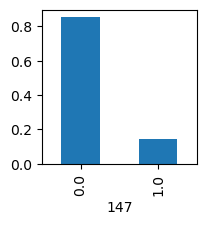

In [18]:
plt.figure(figsize=(2,2))
class_frequency = best5_train[best5_train.shape[1]-1].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar'); 

# Load data #2

## Validation 

In [19]:
features_valid = pd.read_csv(PATH + 'all_features_valid.csv', index_col=0)
target_valid = pd.read_csv(PATH + 'target_valid.csv', index_col=0)
idx_d_valid = pd.read_csv(PATH + 'faiss_idx_and_distances_valid.csv', index_col=0)

In [20]:
features_valid['distance'] = idx_d_valid['1']
features_valid['index'] = idx_d_valid['0']
#idx_valid = idx_d_valid['0']

In [21]:
del idx_d_valid
gc.collect()

2547

## Searching for best candidates

In [22]:
features_valid['prob'] = model.predict_proba(features_valid)[:, 1]
features_valid['target'] = target_valid

creating new smaller valid dataframe:

In [23]:
best5_valid = best_candidates_search(features_valid, n_neigbours, 5, 'valid')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
origin DF deleted...
new DF created!


In [24]:
del features_valid
gc.collect()

0

147
0.0    0.8555
1.0    0.1445
Name: proportion, dtype: float64


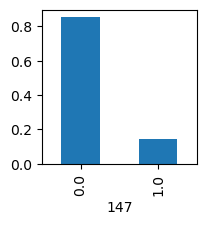

In [25]:
plt.figure(figsize=(2,2))
class_frequency = best5_valid[best5_valid.shape[1]-1].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');  

# CatBoost Classification

## Train

In [26]:
y_train = np.array(best5_train[best5_train.shape[1]-1])
X_train = np.array(best5_train.drop([best5_train.shape[1]-1], axis=1))
del best5_train
gc.collect()

2573

In [27]:
y_valid = np.array(best5_valid[best5_valid.shape[1]-1])
X_valid = np.array(best5_valid.drop([best5_valid.shape[1]-1], axis=1))
#del best5_valid
gc.collect()

0

In [28]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=42, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_train, y_train)

Learning rate set to 0.100906
0:	learn: 0.5630374	total: 360ms	remaining: 8m 59s
500:	learn: 0.1560144	total: 3m 18s	remaining: 6m 35s
1000:	learn: 0.1414385	total: 6m 37s	remaining: 3m 18s
1499:	learn: 0.1311783	total: 9m 57s	remaining: 0us


## Metrics

Accuracy:  0.943
Precision:  0.873
Recall:  0.71
F1-score:  0.783
ROC-AUC:  0.96


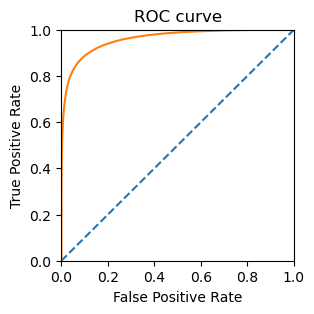

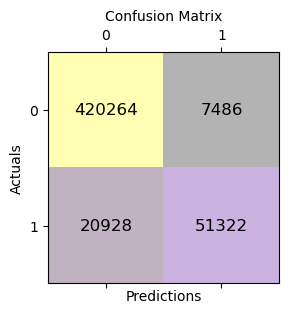

In [29]:
y_pred = model.predict(X_valid)
metrics(y_valid, y_pred, X_valid)

Compare metrics to a DummyClassifier:

In [30]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

Accuracy:  0.753
Precision:  0.146
Recall:  0.146
F1-score:  0.146
ROC-AUC:  0.96


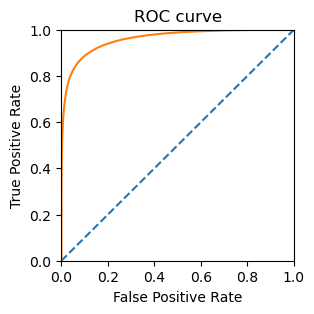

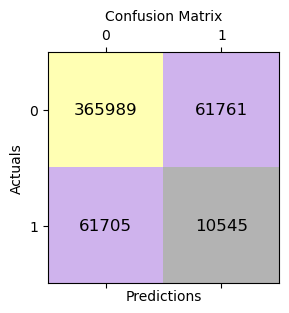

In [31]:
dum_pred = dummy_clf.predict(X_valid)
metrics(y_valid, dum_pred, X_valid)

![Url](https://y.yarn.co/72d3e314-fac3-4392-96af-8c81554f0a9b_text.gif "jack")

For evaluating performance of the model there will be used *F1 score* and *accuracy*. F1 indicates that the model has both high precision and high recall, which means that it’s able to correctly identify positive cases while avoiding false positives and false negatives.

*F1 score* value is 0.708 on validation, and *accuracy* is 0.927.

## Accuracy@5 on validation

In [32]:
targets_valid = pd.read_csv(PATH + 'validation_answer.csv', index_col=0)['Expected']
base_index = open(PATH + 'base_index.txt')
base_index = json.load(base_index)

In [33]:
n=5
best_indexes = []
for i in tqdm(range((len(best5_valid)// n))):
    best_indexes.append(best5_valid[best5_valid.shape[1]-3][n*i:n*(i+1)].tolist())

  0%|          | 0/100000 [00:00<?, ?it/s]

In [34]:
best_indexes_int = []
for i in range(len(best_indexes)):
    l = [int(item) for item in best_indexes[i]]
    best_indexes_int.append(l)

In [35]:
acc =0

for target, el in zip(targets_valid.reset_index(drop=True).values.tolist(), best_indexes_int):
    acc += int(target in [base_index[str(r)] for r in el])   
print('neighbours found: {} %'.format(100 * acc / len(best_indexes_int)))

neighbours found: 72.25 %


# Saving model

In [36]:
model.save_model(PATH + 'matching_model.cbm', format='cbm')